In [1]:
cd /content/drive/MyDrive/lusip

/content/drive/MyDrive/lusip


In [2]:
!ls

 AccVal_acc.png      apple_mobilnet   LossVal_loss.png
 apple		     checkpoint       model_apple.h5
 apple_app1.tflite   data	     'new plant diseases dataset(augmented)'
 apple_app.tflite    heatmap.ipynb   'New Plant Diseases Dataset(Augmented)'
 apple_finetune      lables.txt       try.ipynb


In [3]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np

In [4]:
# model = tf.saved_model.load('apple_mobilnet')
model = tf.keras.models.load_model('apple_finetune')

In [5]:
images = os.listdir('/content/drive/MyDrive/lusip/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab')

In [6]:
len(images)

2016

In [7]:
images.index('fcd4d0fd-30c9-4b05-b0ea-ca74fd3cad72___FREC_Scab 3510_new30degFlipLR.JPG')

836

In [8]:
img = np.asarray(Image.open(os.path.join('/content/drive/MyDrive/lusip/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab', images[892])).resize((224,224)))

In [9]:
img.shape

(224, 224, 3)

In [10]:
x = np.expand_dims(img, axis=0)

In [11]:
preds = model.predict(x)

In [12]:
preds

array([[6.3889714e-13, 1.6818385e-12, 1.0000000e+00, 8.4667291e-12]],
      dtype=float32)

In [13]:
grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('Conv_1').output, model.output]
    )

In [14]:
def make_gradcam(img_array, pred_index=None):
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  print(type(heatmap))
  return heatmap.numpy()

In [15]:
heatmap = make_gradcam(x, 3)

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [16]:
import matplotlib.pyplot as plt

In [17]:
import matplotlib.cm as cm

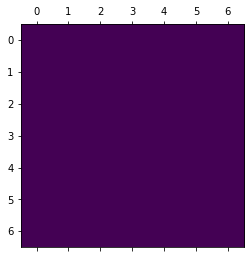

In [18]:
plt.matshow(heatmap)

In [19]:
alpha=0.4

In [20]:
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * alpha + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

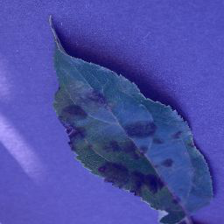

In [21]:
superimposed_img

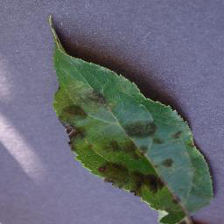

In [22]:
Image.fromarray(img)